In [1]:
%load_ext autoreload
%autoreload 2
from vip_helpers import *
import matplotlib.pyplot as plt

dataclasses, state_dfs, s2p_outs, recording_days = load_animal_data('Front_left')
s2p_dict = dict(zip(recording_days, s2p_outs))
dataclasses_dict = dict(zip(recording_days, dataclasses))
state_dfs_dict = dict(zip(recording_days, state_dfs))
animal_spikes = {rec_day:s2p_out.get_cell_spikes() for rec_day, s2p_out in s2p_dict.items()}
animal_f_traces = {rec_day:s2p_out.calc_deltaF()[0] for rec_day, s2p_out in s2p_dict.items()}

/home/gianna/Desktop/PythonProjects/VIPxTigerAnalyses/twop/getSuite2POutput.py:117: RuntimeWarning: invalid value encountered in divide
  deltaF = (rawF - baseline) / baseline


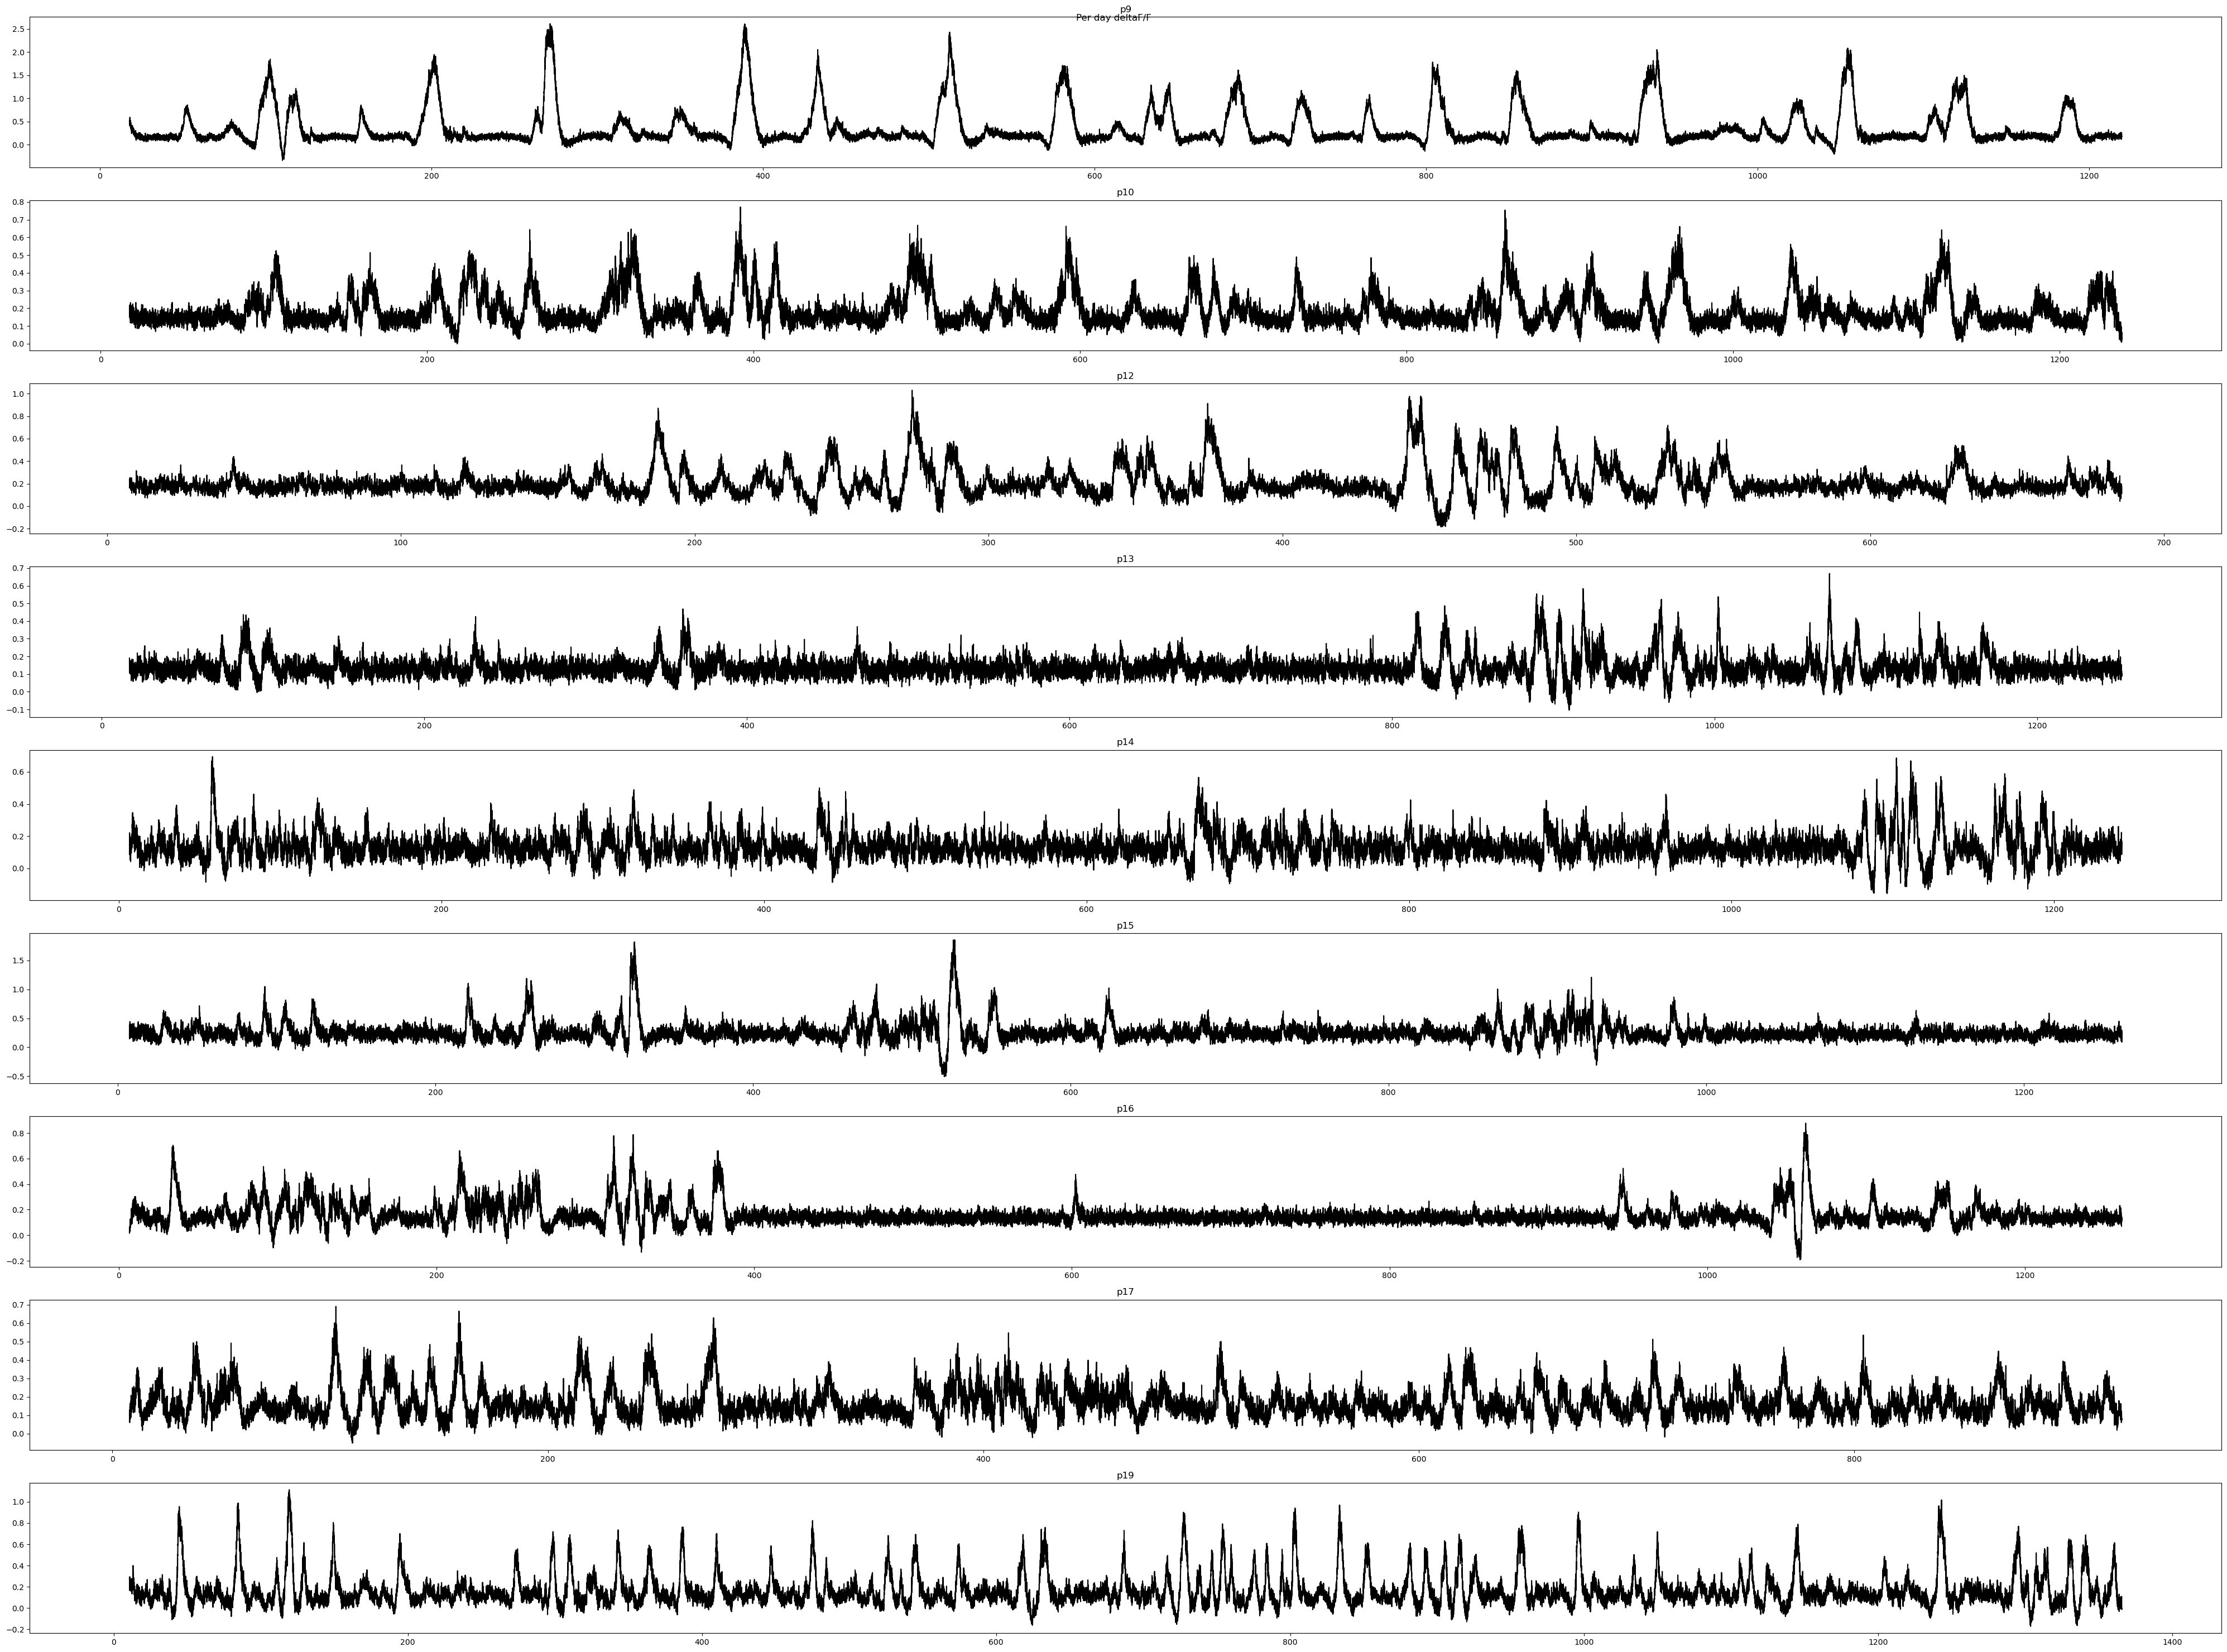

In [48]:
fig, axs = plt.subplots(9, 1, figsize=(40,30))
plt.suptitle('Per day deltaF/F')
for rec_day_idx, rec_day in enumerate(recording_days):
    spike_train = animal_f_traces[rec_day]
    dataclass = dataclasses_dict[rec_day]
    spike_train_avg = np.nanmean(spike_train, axis=0)

    axs[rec_day_idx].plot(dataclass.scope_times, spike_train_avg[:(dataclass.s2p_out.F.shape[1] - len(dataclass.scope_times)) * -1], color='black')
    axs[rec_day_idx].set_title(rec_day)

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(9, 1, figsize=(40,30))
plt.suptitle('Per day spike trains')
for rec_day_idx, rec_day in enumerate(recording_days):
    spike_train = animal_spikes[rec_day]
    dataclass = dataclasses_dict[rec_day]
    spike_train_avg = np.nanmean(spike_train, axis=0)

    axs[rec_day_idx].plot(dataclass.scope_times, spike_train_avg[:(dataclass.s2p_out.F.shape[1] - len(dataclass.scope_times)) * -1], color='black')
    axs[rec_day_idx].set_title(rec_day)

plt.tight_layout()


In [145]:
from utils.alignmentFunctions import motion_to_2p_bins

p9_data = dataclasses_dict['p9']
p9_state_df = state_dfs_dict['p9']
frame_times = p9_data.scope_times
motion_raw = p9_state_df['motion']
motion_times = p9_state_df['time']
motion = motion_to_2p_bins(frame_times, motion_raw, motion_times=motion_times)
motion

array([0.22422402, 0.21813234, 0.21111387, ..., 0.04181512, 0.03814313,
       0.03467453], shape=(35999,))

In [ ]:
from scipy.stats import pearsonr, zscore
from utils.stats import zscore_robust

def corr_motion_dff(dff, motion_at_frames):
    n_cells = dff.shape[0]
    corrs = np.full(n_cells, np.nan)
    valid = ~np.isnan(motion_at_frames)

    m = zscore(motion_at_frames[valid])

    for i in range(n_cells):
        x = zscore(dff[i, valid])
        r, _ = pearsonr(x, m)
        corrs[i] = r

    return corrs

#corrs = motion_correlations(dff, motion_trace)
corr_motion_dff(dff[:, :-1])

In [182]:
all_corrs = []  # list of 1D arrays per day
for rec_day in recording_days:
    dff = animal_f_traces[rec_day]
    dataclass = dataclasses_dict[rec_day]
    frame_times = dataclass.scope_times
    state_df = state_dfs_dict[rec_day]
    motion_raw = state_df['motion']
    motion_times = state_df['time']
    motion_z = zscore(motion_raw)
    motion = motion_to_2p_bins(frame_times, motion_z, motion_times=motion_times)
    motion_time_dff = motion.shape[0] - dff.shape[1]
    print(rec_day, dff.shape, motion_time_dff)
    dff_frames = dff[:,:motion_time_dff]
    corr_vec = corr_motion_dff(dff_frames, motion)  # (n_cells,)
    all_corrs.append(corr_vec)

corr_array = np.vstack(all_corrs)  # shape (n_days, n_cells)

plt.figure(figsize=(8,4))
im = plt.imshow(corr_array, aspect='auto', vmin=-1, vmax=1, cmap='plasma')
plt.xlabel('Cell index')
plt.ylabel('Day index')
plt.colorbar(im, label='Pearson r')
plt.tight_layout()
plt.show()


p9 (322, 36000) -1
p10 (308, 36000) -1
p12 (272, 20000) -1
p13 (259, 37000) -1
p14 (225, 37000) -1
p15 (166, 37000) -1
p16 (336, 37000) -1
p17 (231, 27000) -1
p19 (295, 40000) -24


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 322 and the array at index 1 has size 308

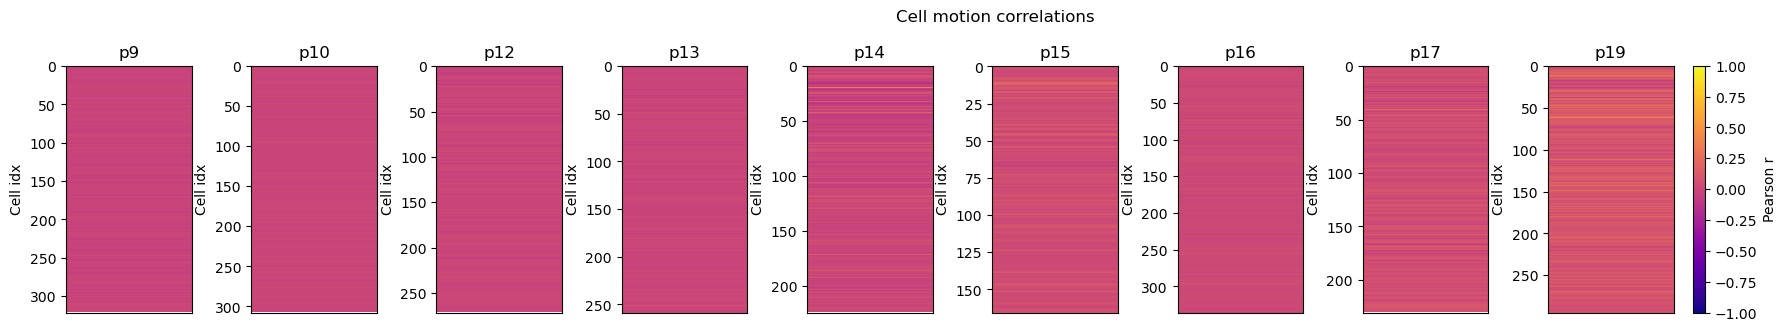

In [201]:
# fig, axs = plt.subplots(1, len(all_corrs), figsize=(35, 5))
rec_day_idx = 0
# for i, corr_vec in enumerate(all_corrs):
#     im = axs[i].imshow(corr_vec[np.newaxis, :],
#                        aspect='auto', vmin=-1, vmax=1, cmap='plasma')
#     axs[i].set_yticks([])
#     axs[i].set_xlabel('Cell idx')
#     axs[i].set_title(f'{recording_days[rec_day_idx]}')
#     rec_day_idx += 1
# cbar = fig.colorbar(im, ax=axs.ravel().tolist(), location='right')
# cbar.set_label('Pearson r')
# plt.tight_layout()
# plt.show()
# plt.suptitle('Cell motion correlations')
fig, axs = plt.subplots(1, len(all_corrs), figsize=(20, 3))

ims = []  # store image handles
for i, corr_vec in enumerate(all_corrs):
    # flip so cell index is Y-AXIS: shape (cells, 1)
    im = axs[i].imshow(
        corr_vec[:, np.newaxis],  # (n_cells, 1)
        aspect='auto',
        vmin=-1, vmax=1,
        cmap='plasma'
    )
    ims.append(im)
    axs[i].set_xticks([])
    axs[i].set_ylabel("Cell idx")
    axs[i].set_title(f'{recording_days[rec_day_idx]}')
    rec_day_idx += 1
plt.tight_layout()   # <-- IMPORTANT before colorbar

# shared colorbar OUTSIDE on far right
cbar = fig.colorbar(
    ims[-1],                    # use last imshow handle
    ax=axs.ravel().tolist(),
    location='right',
    pad=0.01                    # SMALL pad for wide figures
)
cbar.set_label('Pearson r')

plt.suptitle('Cell motion correlations', y=1.07)
plt.show()



TypeError: Invalid shape (322,) for image data

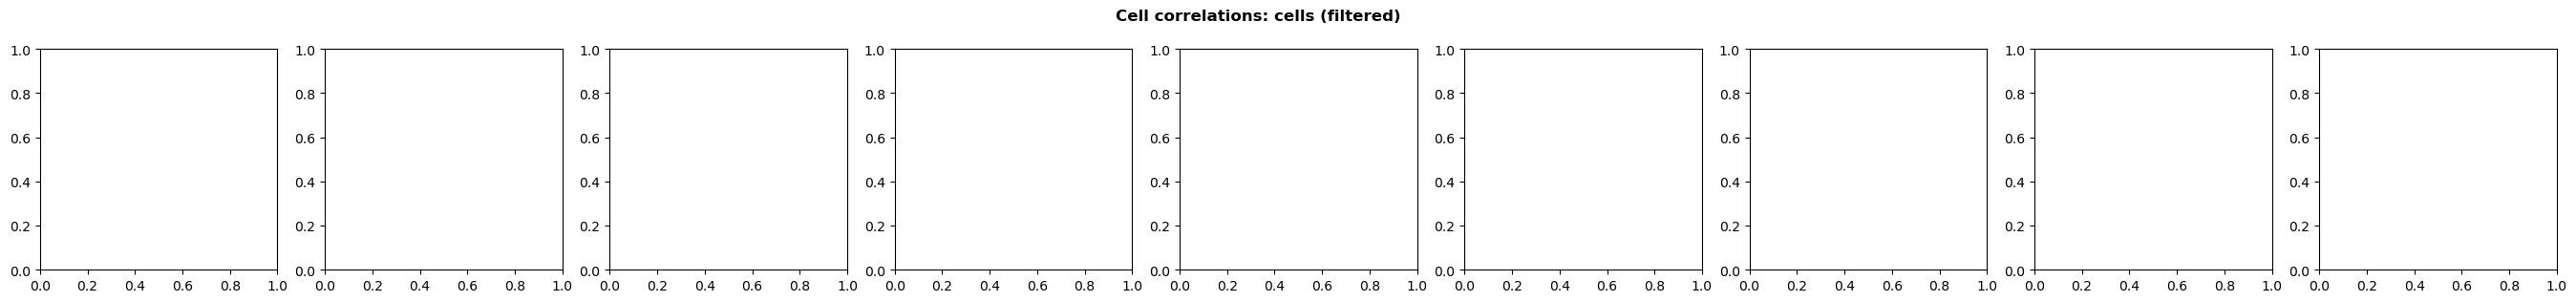

In [ ]:
import random

fig, axs = plt.subplots(1,9, figsize=(34,3))
plt.suptitle('Cell correlations: cells (filtered)',  y=1.02, fontweight='bold')
for rec_day_idx, rec_day in enumerate(recording_days):
    dff = animal_f_traces[rec_day]
    spikes = animal_spikes[rec_day]
    dataclass = dataclasses_dict[rec_day]
    frame_times = dataclass.scope_times
    state_df = state_dfs_dict[rec_day]
    motion_raw = state_df['motion']
    motion_times = state_df['time']
    motion = motion_to_2p_bins(frame_times, motion_raw, motion_times=motion_times)
    corr_mat = corr_motion_dff(dff[:,:-1], motion)
    im = axs[rec_day_idx].imshow(corr_mat, aspect='auto', vmin=-1, vmax=1, cmap = 'plasma')

# cbar = fig.colorbar(
#     im,
#     ax=axs.ravel().tolist(),
#     location='right',
#     pad=.01)


# cbar.set_label('Pearson r')
# plt.show()


Good cells: 284 / 322
Good cells: 270 / 308
Good cells: 240 / 272
Good cells: 230 / 259
Good cells: 199 / 225
Good cells: 145 / 166
Good cells: 295 / 336
Good cells: 202 / 231
Good cells: 262 / 295


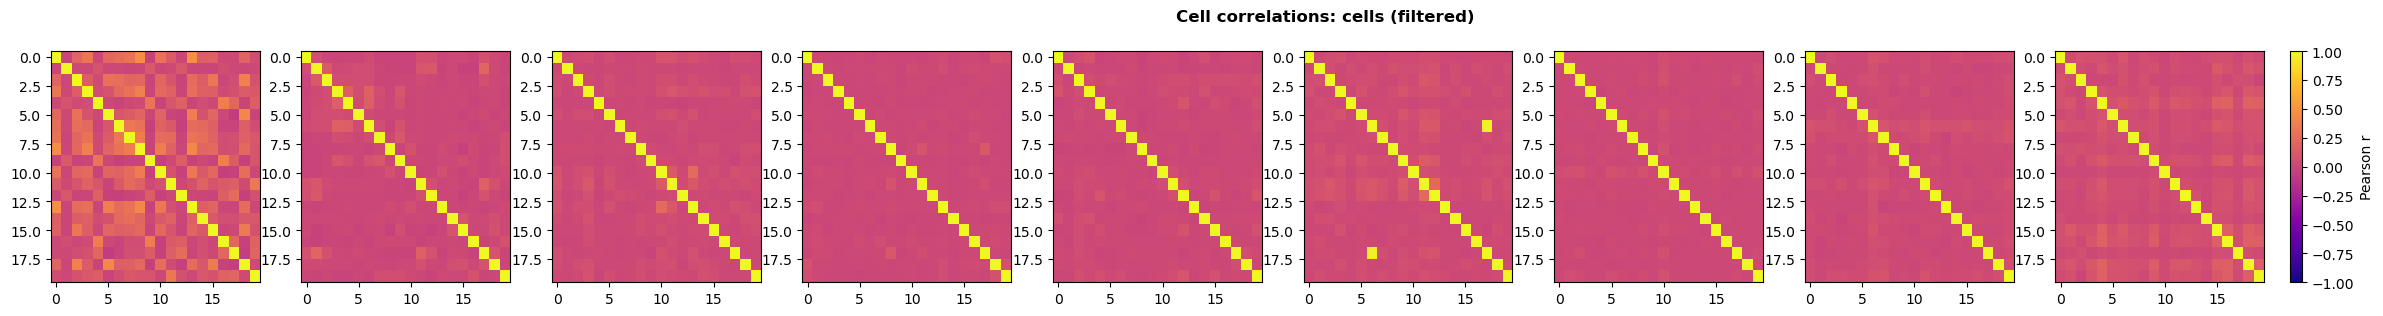

In [ ]:
# subset = good_cells[:100]
# X = dff[subset]   # (cells, time)
import random
fig, axs = plt.subplots(1,9, figsize=(34,3))
plt.suptitle('Cell correlations: cells (filtered)',  y=1.02, fontweight='bold')
for rec_day_idx, rec_day in enumerate(recording_days):
    dff = animal_f_traces[rec_day]
    spikes = animal_spikes[rec_day]
    dataclass = dataclasses_dict[rec_day]
    good_cells = get_good_cells(dff, spikes)
    subset= good_cells
    subset = np.random.choice(good_cells, size=20, replace=False)
    X = dff[subset]
    # time x cells for np.corrcoef
    corr_mat = np.corrcoef(X)
    im = axs[rec_day_idx].imshow(corr_mat, aspect='auto', vmin=-1, vmax=1, cmap = 'plasma')

cbar = fig.colorbar(
    im,
    ax=axs.ravel().tolist(),
    location='right',
    pad=.01)


cbar.set_label('Pearson r')
plt.show()


WARNING!! Returned 36759 frames but was provided with 35999
WARNING!! Returned 38063 frames but was provided with 35999
WARNING!! Returned 20631 frames but was provided with 19999
WARNING!! Returned 38608 frames but was provided with 36999
WARNING!! Returned 38001 frames but was provided with 36999
WARNING!! Returned 38140 frames but was provided with 36999
WARNING!! Returned 38950 frames but was provided with 36999
WARNING!! Returned 28361 frames but was provided with 26999
WARNING!! Returned 40732 frames but was provided with 39976


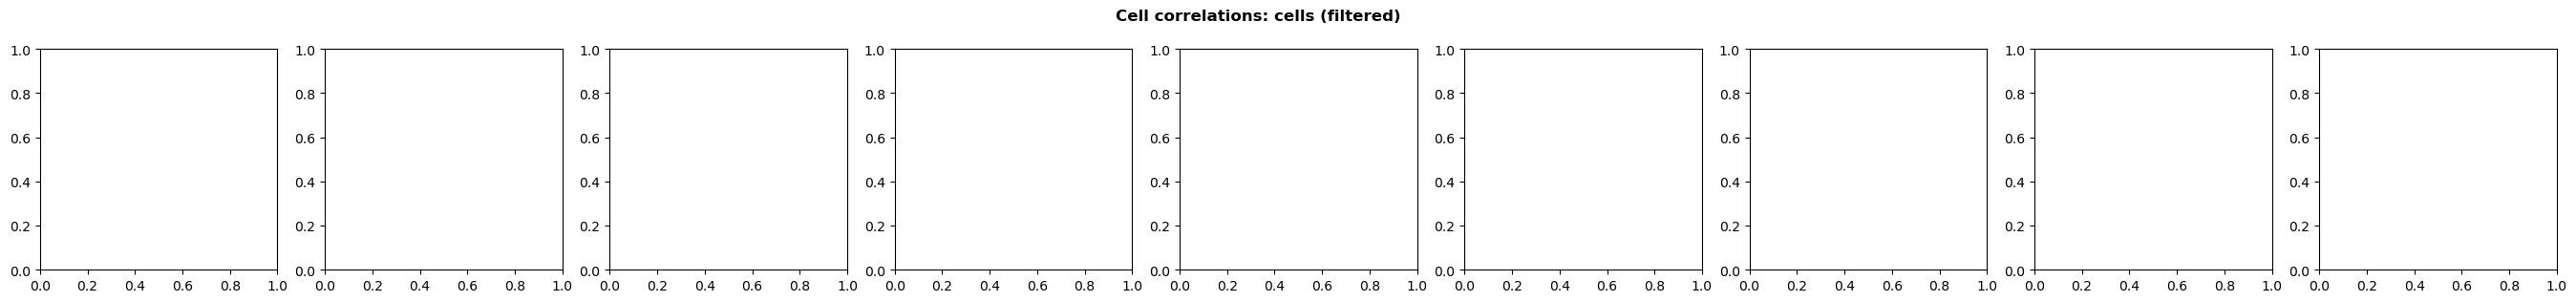

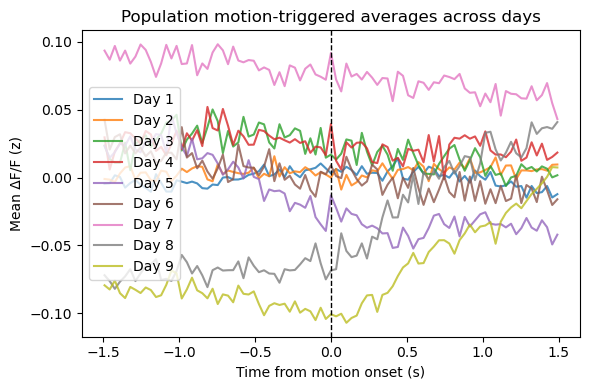

In [ ]:
pop_traces= []
plt.suptitle('Cell correlations: cells (filtered)',  y=1.02, fontweight='bold')
for rec_day_idx, rec_day in enumerate(recording_days):
    dff = animal_f_traces[rec_day]
    dataclass = dataclasses_dict[rec_day]
    frame_times = dataclass.scope_times
    state_df = state_dfs_dict[rec_day]
    motion_raw = state_df['motion']
    motion_times = state_df['time']
    motion = motion_to_2p_bins(frame_times, motion_raw, motion_times=motion_times)
    t_win, mta_pop, mta_cells, onset_idx = compute_mta(
        dff, frame_times, motion,
        pre_s=1.5, post_s=1.5,
        high_percentile=80, min_gap_s=2.0,
        zscore_cells=True
    )
    pop_traces.append(mta_pop)
pop_traces = restrict_traces(pop_traces)

# pop_traces: list of (n_win,) arrays, same t_win
plt.figure(figsize=(6, 4))
for i, mta_pop in enumerate(pop_traces):
    plt.plot(t_win, mta_pop, label=f'Day {i+1}', alpha=0.8)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Time from motion onset (s)')
plt.ylabel('Mean ΔF/F (z)')
plt.title('Population motion-triggered averages across days')
plt.legend()
plt.tight_layout()
plt.show()


WARNING!! Returned 36759 frames but was provided with 35999
WARNING!! Returned 38063 frames but was provided with 35999
WARNING!! Returned 20631 frames but was provided with 19999
WARNING!! Returned 38608 frames but was provided with 36999
WARNING!! Returned 38001 frames but was provided with 36999
WARNING!! Returned 38140 frames but was provided with 36999
WARNING!! Returned 38950 frames but was provided with 36999
WARNING!! Returned 28361 frames but was provided with 26999
WARNING!! Returned 40732 frames but was provided with 39976


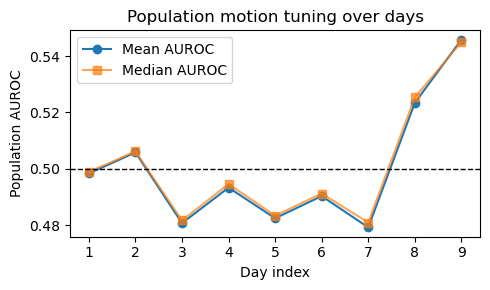

In [ ]:
auroc_means = []
auroc_medians = []
auroc_all_days = []   # store full distributions per day

for rec_day in recording_days:
    dff = animal_f_traces[rec_day]     
    dataclass = dataclasses_dict[rec_day]
    frame_times = dataclass.scope_times
    state_df = state_dfs_dict[rec_day]
    motion_raw = state_df['motion']
    motion_times = state_df['time']
    motion = motion_to_2p_bins(frame_times, motion_raw, motion_times=motion_times)
    motion_time_dff = motion.shape[0] - dff.shape[1]
    dff_frames = dff[:,:motion_time_dff]

    auroc_vals, labels = compute_auroc_motion_per_cell(dff_frames, motion, high_percentile=80)

    auroc_all_days.append(auroc_vals)
    auroc_means.append(np.nanmean(auroc_vals))
    auroc_medians.append(np.nanmedian(auroc_vals))
day_idx = np.arange(1, len(recording_days) + 1)

plt.figure(figsize=(5, 3))
plt.plot(day_idx, auroc_means, marker='o', label='Mean AUROC')
plt.plot(day_idx, auroc_medians, marker='s', label='Median AUROC', alpha=0.7)
plt.axhline(0.5, color='k', linestyle='--', linewidth=1)
plt.xlabel('Day index')
plt.ylabel('Population AUROC')
plt.title('Population motion tuning over days')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.boxplot([a[~np.isnan(a)] for a in auroc_all_days],
            positions=day_idx, widths=0.6)
plt.axhline(0.5, color='k', linestyle='--', linewidth=1)
plt.xticks(day_idx, [str(d) for d in recording_days], rotation=45)
plt.ylabel('AUROC')
plt.xlabel('Day')
plt.title('Distribution of cell-wise AUROC per day')
plt.tight_layout()
plt.show()


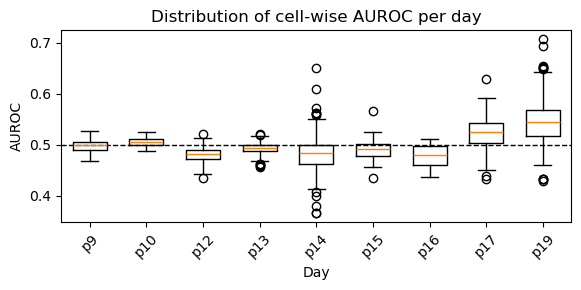

In [10]:
plt.figure(figsize=(6, 3))
plt.boxplot([a[~np.isnan(a)] for a in auroc_all_days],
            positions=day_idx, widths=0.6)
plt.axhline(0.5, color='k', linestyle='--', linewidth=1)
plt.xticks(day_idx, [str(d) for d in recording_days], rotation=45)
plt.ylabel('AUROC')
plt.xlabel('Day')
plt.title('Distribution of cell-wise AUROC per day')
plt.tight_layout()
plt.show()


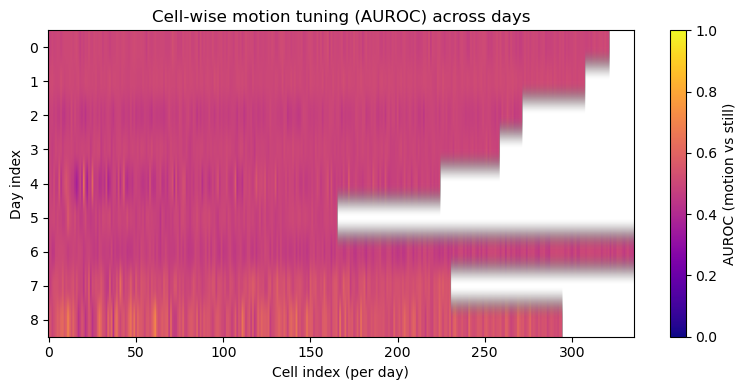

In [13]:
n_days = len(auroc_all_days)
max_cells = max(a.size for a in auroc_all_days)
auroc_mat = np.full((n_days, max_cells), np.nan)
for i, a in enumerate(auroc_all_days):
    auroc_mat[i, :a.size] = a
auroc_mat = restrict_traces(auroc_mat)
plt.figure(figsize=(8, 4))
im = plt.imshow(auroc_mat, aspect='auto', vmin=0, vmax=1, cmap='plasma')
plt.colorbar(im, label='AUROC (motion vs still)')
plt.xlabel('Cell index (per day)')
plt.ylabel('Day index')
plt.title('Cell-wise motion tuning (AUROC) across days')
plt.tight_layout()
plt.show()


WARNING!! Returned 36759 frames but was provided with 35999


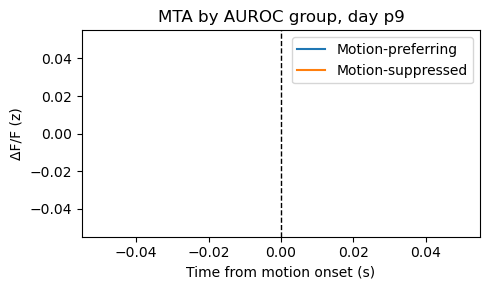

WARNING!! Returned 38063 frames but was provided with 35999


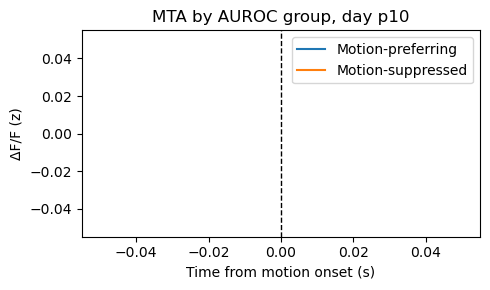

WARNING!! Returned 20631 frames but was provided with 19999


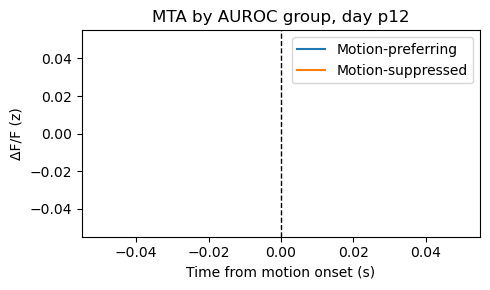

WARNING!! Returned 38608 frames but was provided with 36999


KeyboardInterrupt: 

In [ ]:
thr_hi = 0.6
thr_lo = 0.4
from state.motion_correlations import *
for rec_day_idx, rec_day in enumerate(recording_days):
    dff = animal_f_traces[rec_day]
    dataclass = dataclasses_dict[rec_day]
    frame_times = dataclass.scope_times
    state_df = state_dfs_dict[rec_day]
    motion_raw = state_df['motion']
    motion_times = state_df['time']
    motion = motion_to_2p_bins(frame_times, motion_raw, motion_times=motion_times)
    motion_time_diff = motion.shape[0] - dff.shape[1]
    dff_frames = dff[:,:motion_time_diff]
    auroc_vals, labels = compute_auroc_motion_per_cell(dff_frames, motion)
    motion_pref = np.where(auroc_vals > thr_hi)[0]
    motion_supp = np.where(auroc_vals < thr_lo)[0]

    t_win, mta_pop_all, mta_cells, onset_idx = compute_mta(
        dff_frames, frame_times, motion, pre_s=3, post_s=3                                  ,
        high_percentile=70, min_gap_s=2, zscore_cells=True)

    mta_pref = np.nanmean(mta_cells[motion_pref], axis=0) if motion_pref.size > 0 else np.full_like(mta_pop_all, np.nan)
    mta_supp = np.nanmean(mta_cells[motion_supp], axis=0) if motion_supp.size > 0 else np.full_like(mta_pop_all, np.nan)

    plt.figure(figsize=(5,3))
    plt.plot(t_win, mta_pref, label='Motion-preferring')
    plt.plot(t_win, mta_supp, label='Motion-suppressed')
    plt.axvline(0, color='k', ls='--', lw=1)
    plt.xlabel('Time from motion onset (s)')
    plt.ylabel('ΔF/F (z)')
    plt.title(f'MTA by AUROC group, day {rec_day}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def compute_mta_new(
    dff,
    frame_times,
    motion_at_frames,
    pre_s=3.0,
    post_s=3.0,
    high_percentile=80,
    min_gap_s=2.0,
    zscore_cells=False,
    verbose=False,
    day_label=None,
):
    dff = np.asarray(dff)
    t = np.asarray(frame_times)
    motion = np.asarray(motion_at_frames)

    n_cells, n_frames = dff.shape
    dt = np.median(np.diff(t))

    pre_frames = int(np.round(pre_s / dt))
    post_frames = int(np.round(post_s / dt))
    win = pre_frames + post_frames + 1

    # optionally z-score per cell
    if zscore_cells:
        mu = np.nanmean(dff, axis=1, keepdims=True)
        sd = np.nanstd(dff, axis=1, keepdims=True) + 1e-8
        dff_z = (dff - mu) / sd
    else:
        dff_z = dff

    # mask NaNs in motion
    valid_motion = ~np.isnan(motion)
    if valid_motion.sum() < 10:
        if verbose:
            print(f"[MTA] {day_label}: <10 valid motion frames, skipping.")
        t_win = np.arange(-pre_frames, post_frames+1) * dt
        return t_win, np.full(win, np.nan), np.full((n_cells, win), np.nan), np.array([])

    motion_valid = motion[valid_motion]
    # threshold
    thr = np.nanpercentile(motion_valid, high_percentile)
    moving = motion > thr

    # detect onsets
    onset_idx = np.where(np.diff(moving.astype(int)) == 1)[0] + 1

    if verbose:
        print(f"[MTA] {day_label}: total onsets (raw) = {len(onset_idx)}")

    if len(onset_idx) == 0:
        if verbose:
            print(f"[MTA] {day_label}: no motion onsets above {high_percentile}th percentile.")
        t_win = np.arange(-pre_frames, post_frames+1) * dt
        return t_win, np.full(win, np.nan), np.full((n_cells, win), np.nan), np.array([])

    # enforce min gap
    min_gap_frames = int(np.round(min_gap_s / dt))
    kept = [onset_idx[0]]
    for idx in onset_idx[1:]:
        if idx - kept[-1] >= min_gap_frames:
            kept.append(idx)
    onset_idx = np.array(kept, dtype=int)

    if verbose:
        print(f"[MTA] {day_label}: onsets after min_gap_s={min_gap_s} → {len(onset_idx)}")

    # build trials
    trials = []
    kept_onsets = []
    for idx in onset_idx:
        start = idx - pre_frames
        end = idx + post_frames + 1
        if start < 0 or end > n_frames:
            continue
        trials.append(dff_z[:, start:end])
        kept_onsets.append(idx)

    if verbose:
        print(f"[MTA] {day_label}: onsets with full window inside recording → {len(kept_onsets)}")

    t_win = np.arange(-pre_frames, post_frames+1) * dt

    if len(trials) == 0:
        if verbose:
            print(f"[MTA] {day_label}: no usable trials, returning NaNs.")
        return t_win, np.full(win, np.nan), np.full((n_cells, win), np.nan), np.array([])

    trials = np.stack(trials, axis=0)       # (trials, cells, win)
    mta_cells = np.nanmean(trials, axis=0)  # (cells, win)
    mta_pop = np.nanmean(mta_cells, axis=0) # (win,)

    return t_win, mta_pop, mta_cells, np.array(kept_onsets, dtype=int)



pop_traces = []
t_wins = []
valid_day_labels = []

for rec_day in rec_days:
    dff = animal_f_traces[rec_day]
    frame_times = animal_frame_times[rec_day]
    motion_at_frames = motion_at_frames_per_day[rec_day]  # your aligned motion

    t_win, mta_pop, mta_cells, onset_idx = compute_mta(
        dff,
        frame_times,
        motion_at_frames,
        pre_s=3.0,
        post_s=3.0,
        high_percentile=80,
        min_gap_s=2.0,
        zscore_cells=True,
        verbose=True,
        day_label=str(rec_day),
    )

    if len(onset_idx) == 0 or np.all(np.isnan(mta_pop)):
        print(f"[MTA] Skipping day {rec_day} (no valid motion-triggered trials).")
        continue

    pop_traces.append(mta_pop)
    t_wins.append(t_win)
    valid_day_labels.append(rec_day)

plt.figure(figsize=(6, 4))
for i, (t_win_i, mta_pop) in enumerate(zip(t_wins, pop_traces)):
    plt.plot(t_win_i, mta_pop, label=f'Day {valid_day_labels[i]}', alpha=0.8)

plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Time from motion onset (s)')
plt.ylabel('Mean ΔF/F (z)')
plt.title('Population motion-triggered averages across days')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'rec_days' is not defined